In [1]:
import sys
import os
import numpy as np
import sympy as sp

# Add the parent directory and src directory to Python path
project_root = os.path.dirname(os.getcwd())
src_path = os.path.join(project_root, 'src')
sys.path.insert(0, project_root)
sys.path.insert(0, src_path)

# First import matrix_utils to make it available for seesaw module
#import matrix_utils

# Now we need to temporarily fix the import issue by importing functions into global namespace
from matrix_utils import (diagonalize_mass_matrix, mass_squared_differences,
                          create_symbolic_matrix, seesaw_approximation_symbolic,
                          substitute_numerical_values, symbolic_rotation_matrix,
                          sin_cos_from_tan_fraction)

# Add these to matrix_utils module namespace to satisfy relative imports
sys.modules['matrix_utils'].diagonalize_mass_matrix = diagonalize_mass_matrix
sys.modules['matrix_utils'].mass_squared_differences = mass_squared_differences
sys.modules['matrix_utils'].create_symbolic_matrix = create_symbolic_matrix
sys.modules['matrix_utils'].seesaw_approximation_symbolic = seesaw_approximation_symbolic
sys.modules['matrix_utils'].substitute_numerical_values = substitute_numerical_values
sys.modules['matrix_utils'].symbolic_rotation_matrix = symbolic_rotation_matrix
sys.modules['matrix_utils'].sin_cos_from_tan_fraction = sin_cos_from_tan_fraction

# Now import seesaw with absolute imports instead of relative
exec(open(os.path.join(src_path, 'seesaw.py')).read().replace('from .matrix_utils import', 'from matrix_utils import'))

print("Successfully loaded SymbolicSeesawTypeI!")
print(f"Available methods: {[method for method in dir(SymbolicSeesawTypeI) if not method.startswith('_')]}")

Successfully loaded SymbolicSeesawTypeI!
Available methods: ['MConjugateMT', 'MDaggerM', 'charpoly_relations', 'evaluate_numerically', 'full_mass_matrix_symbolic', 'left_eigenvectors', 'light_mass_matrix_symbolic', 'neutrino_mass_differences_dummyes', 'perturbative_expansion', 'right_eigenvectors', 'scaling_analysis', 'set_texture', 'simplified_2x2_case']


# One generation of each neutrino case

In [2]:
from sympy import init_printing, symbols, solve, sin, cos, factor, Matrix, conjugate, I, sqrt, tan, Dummy
from sympy.physics.quantum import Dagger
init_printing()

In [3]:
seesaw = SymbolicSeesawTypeI(n_generations=1, n_sterile=1)
seesaw

SymbolicSeesawTypeI(n_generations=1, n_sterile=1)

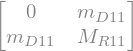

In [4]:
Mnu2x2 = seesaw.full_mass_matrix_symbolic()
Mnu2x2

In [5]:
charpoly_relations = seesaw.charpoly_relations()

In [6]:
charpoly_relations['char_poly_M']

In [7]:
charpoly_relations['char_poly_diag']

In [8]:
import pandas as pd
from sympy import latex, sympify

# Create a DataFrame to display the coefficients side by side
charpoly_relations_latex = charpoly_relations.copy()
charpoly_relations_latex['coefficients_full_matrix'] = {
    f"${key}$": f"${latex(value)}$" for key, value in charpoly_relations_latex['coefficients_full_matrix'].items()
}
charpoly_relations_latex['coefficients_diagonal'] = {
    f"${key}$": f"${latex(value)}$" for key, value in charpoly_relations_latex['coefficients_diagonal'].items()
}
df_coeffs = pd.DataFrame({
    "Full Matrix": charpoly_relations_latex["coefficients_full_matrix"],
    "Diagonal Matrix": charpoly_relations_latex["coefficients_diagonal"]
})
df_coeffs

,Full Matrix,Diagonal Matrix
$lambda^0$,$- m_{D 11}^{2}$,$m_{n_1} m_{n_2}$
$lambda^1$,$- M_{R 11}$,$- m_{n_1} - m_{n_2}$
$lambda^2$,$1$,$1$


In [9]:
print(df_coeffs.to_markdown())

|            | Full Matrix      | Diagonal Matrix       |
|:-----------|:-----------------|:----------------------|
| $lambda^0$ | $- m_{D 11}^{2}$ | $m_{n_1} m_{n_2}$     |
| $lambda^1$ | $- M_{R 11}$     | $- m_{n_1} - m_{n_2}$ |
| $lambda^2$ | $1$              | $1$                   |


|            | Full Matrix      | Diagonal Matrix       |
|:-----------|:-----------------|:----------------------|
| $\lambda^0$ | $- m_{D 11}^{2}$ | $m_{n_1} m_{n_2}$     |
| $\lambda^1$ | $- M_{R 11}$     | $- m_{n_1} - m_{n_2}$ |
| $\lambda^2$ | $1$              | $1$                   |

In [10]:
# Automatically construct equations for each coefficient in the characteristic polynomial
eqs_charpoly = [
    charpoly_relations['coefficients_full_matrix'][key] - charpoly_relations['coefficients_diagonal'][key]
    for key in charpoly_relations['coefficients_full_matrix']
]
eqs_charpoly

In [11]:
seesaw_parameters_sols = solve(eqs_charpoly, 
      seesaw.m_D_sym[0,0], seesaw.M_R_sym[0,0], dict=True)
seesaw_parameters_sols

In [12]:
dummy_differences = seesaw.neutrino_mass_differences_dummyes()
dummy_differences

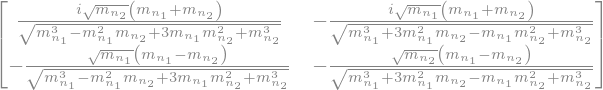

In [14]:

R = seesaw.right_eigenvectors(substitutions=seesaw_parameters_sols[1]).applyfunc(
    lambda x:x.factor().subs(
        dummy_differences
    ).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor()
)
R

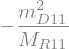

In [16]:
seesaw.light_mass_matrix_symbolic()[0]

In [36]:
from sympy import exp

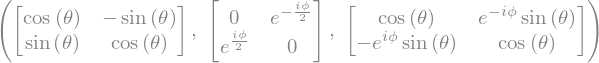

In [46]:
th = symbols('theta', real=True)
phi = symbols('phi', real=True)
Rth = symbolic_rotation_matrix(dim=2, axis=1, angle=th)
P = Matrix(
    [
        [0, exp(-I*phi/2)],
        [exp(I*phi/2), 0]
    ]
)
Omega = Dagger(P)*Rth*P
Rth, P, Omega

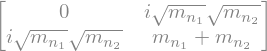

In [77]:
Mnu2x2_masses = seesaw.full_mass_matrix_symbolic().subs(seesaw_parameters_sols[1])
Mnu2x2_masses

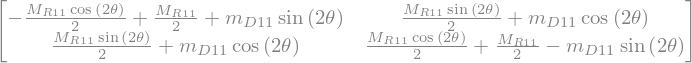

In [54]:
Mnu2x2_diag =  (Rth.T*Mnu2x2*Rth).applyfunc( lambda x:x.trigsimp())
Mnu2x2_diag

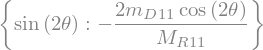

In [56]:
sin2th_sol = solve(Mnu2x2_diag[0, 1], sin(2*th), dict=True)[0]
sin2th_sol

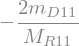

In [57]:
tan2th = sin2th_sol[sin(2*th)]/cos(2*th)
tan2th

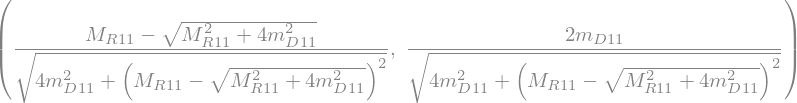

In [58]:
sin2th, cos2th = sin_cos_from_tan_fraction(tan2th)
#display(sin2th, cos2th)
tanth = ((1 - cos2th)/sin2th).factor()
sinth, costh = sin_cos_from_tan_fraction(tanth)
sinth, costh

In [61]:
(sinth**2 + costh**2).factor()

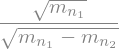

In [70]:
sinth.subs(seesaw_parameters_sols[1]).factor(deep=True).subs(
        dummy_differences
    ).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor()


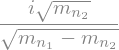

In [72]:
costh.subs(seesaw_parameters_sols[1]).factor(deep=True).subs(
        dummy_differences
    ).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor()

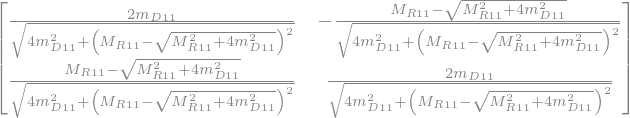

In [60]:
Rth_seesaw = Rth.subs(
    {
        sin(th):sinth,
        cos(th):costh
    }
)
Rth_seesaw

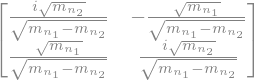

In [75]:
Rth_seesaw2 = Rth_seesaw.subs(seesaw_parameters_sols[1]).applyfunc(lambda x: x.factor(deep=True).subs(
        dummy_differences
    ).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor())
Rth_seesaw2


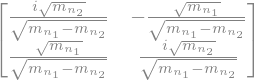

In [93]:
Rth_seesaw2.applyfunc(lambda x: x.subs(
        dummy_differences
    ).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor())

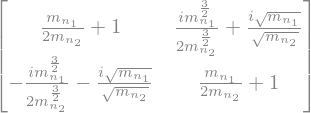

In [96]:
epsilon = symbols('epsilon', positive=True)
mn = seesaw.masses
Rth_seesaw2_approx = Rth_seesaw2.applyfunc(
    lambda x:x.subs(mn[0], epsilon*mn[1]).series(epsilon, 0, 2).removeO().subs(epsilon, mn[0]/mn[1])
)
Rth_seesaw2_approx

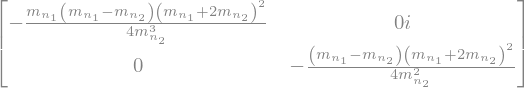

In [98]:
(Rth_seesaw2_approx.T*Mnu2x2_masses*Rth_seesaw2_approx).applyfunc(factor)

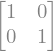

In [82]:
(Rth_seesaw2.T*Rth_seesaw2).applyfunc(lambda x: x.factor())

In [85]:
Rth_seesaw2.det()

In [90]:
(Rth_seesaw2.col(0).T*Rth_seesaw2.col(0))[0].factor()

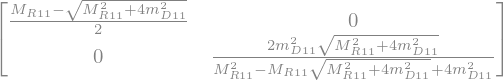

In [63]:
Mnu2x2_masses = (Rth_seesaw.T*Mnu2x2*Rth_seesaw).applyfunc(lambda x:x.factor())
Mnu2x2_masses

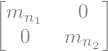

In [78]:
Mnu2x2_masses2 = (Rth_seesaw2.T*Mnu2x2_masses*Rth_seesaw2).applyfunc(lambda x:x.factor())
Mnu2x2_masses2

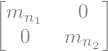

In [67]:
Mnu2x2_masses.subs(seesaw_parameters_sols[1]).applyfunc(
    lambda x: x.factor(deep=True).subs(
        dummy_differences
    ).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor()
)